In [5]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib

In [6]:
matplotlib.rcParams.update({'font.size': 30})

In [7]:
from scrape import aemo, cen

In [8]:
years = range(2016, 2020)

## Australia Energy Consumption

In [9]:
regions = ["NSW", "QLD", "VIC", "SA", "TAS"]

In [10]:
au = aemo.AEMO(regions, years)
au_data = au.get_aemo_data()

In [11]:
len(au.errors)

0

In [12]:
au_data = au_data.dropna().reset_index(drop=True)

In [13]:
au_timezones = {
    "NSW": {
        "conversion": 10,
        "dst": True
    },
    "QLD": {
        "conversion": 10,
        "dst": False
    },
    "VIC": {
        "conversion": 10,
       "dst": True
    },
    "SA": {
        "conversion": 9.5,
        "dst": True
    },
    "TAS": {
        "conversion": 10,
        "dst": True
    }
}

In [14]:
au_dst = {
    2016: {
        "end": datetime.datetime(year=2016, month=4, day=3, hour=3),#"2016040303", # yyyymmddhh (-1 hour)
        "start": datetime.datetime(year=2016, month=10, day=2, hour=2)#"2016100202" # (+1 hour)
    },
    2017: {
        "end": datetime.datetime(year=2017, month=4, day=2, hour=3),#"2017040203",
        "start": datetime.datetime(year=2017, month=10, day=1, hour=2)#"2017100102"
    },
    2018: {
        "end": datetime.datetime(year=2018, month=4, day=1, hour=3), #"2018040103",
        "start": datetime.datetime(year=2018, month=10, day=7, hour=2)#"2018100702"
    },
    2019: {
        "end": datetime.datetime(year=2019, month=4, day=7, hour=3),#"2019040703",
        "start": datetime.datetime(year=2019, month=10, day=6, hour=2)#"2019100602"
    },
    2020: {
        "end": datetime.datetime(year=2020, month=4, day=5, hour=3),#"2020040503",
        "start": datetime.datetime(year=2020, month=10, day=4, hour=2)#"2020100402"
    }
}

In [15]:
def get_au_time_adjustment(region, date):
    year = date.year
    dst_start = au_dst[year]["start"]
    dst_end = au_dst[year]["end"]
    
    region = region.replace("1","")
    
    if au_timezones[region]["dst"] == True:
        if date >= dst_start:
            time_adjustment = au_timezones[region]["conversion"] - 1
        else:
            time_adjustment = au_timezones[region]["conversion"]
    else:
        time_adjustment = au_timezones[region]["conversion"]
        
    return time_adjustment

In [16]:
def convert_au_timezones(settlement_date, time_adjustment):
    utc = settlement_date + datetime.timedelta(hours=time_adjustment)
    utc_hourly = datetime.datetime(year = settlement_date.year, month=settlement_date.month, day=settlement_date.day, hour=settlement_date.hour)
    return utc_hourly

In [17]:
au_data["year"] = au_data["SETTLEMENTDATE"].map(lambda x: x.year)

In [18]:
au_data["date"] = au_data["SETTLEMENTDATE"].map(lambda x: (x.year, x.month, x.day))

In [19]:
au_data["time_adjustment"] = au_data.apply(lambda x: get_au_time_adjustment(x["REGION"], x["SETTLEMENTDATE"]), axis=1)

In [20]:
au_data["utc"] = au_data.apply(lambda x: convert_au_timezones(x["SETTLEMENTDATE"], x["time_adjustment"]), axis=1)

In [21]:
au_hourly = au_data.groupby(['REGION', "year", 'utc']).agg({'TOTALDEMAND':"sum"}).reset_index()

In [22]:
expected_annual_hours = 365*24
print(expected_annual_hours)

8760


In [23]:
au_hourly.groupby(["REGION", "year"]).agg(total_hours=("utc", "count"))

total_hours
REGION year             
NSW1   2016         8784
       2017         8760
       2018         8760
       2019         8760
       2020            1
QLD1   2016         8784
       2017         8760
       2018         8760
       2019         8760
       2020            1
SA1    2016         8784
       2017         8760
       2018         8760
       2019         8760
       2020            1
TAS1   2016         8784
       2017         8760
       2018         8760
       2019         8760
       2020            1
VIC1   2016         8784
       2017         8760
       2018         8760
       2019         8760
       2020            1

In [24]:
au_hourly["source"] = "AU"
au_hourly.rename(columns={"utc": "timestamp", "REGION": "pca_abbrev", "TOTALDEMAND": "load_mw"}, inplace=True)

In [25]:
au_hourly[["timestamp", "pca_abbrev", "load_mw", "source"]].to_csv("data/australia_hourly_consumption.csv", index=None)

In [26]:
au_hourly.head()

,pca_abbrev,year,timestamp,load_mw,source
0,NSW1,2016,2016-01-01 00:00:00,6976.20,AU
1,NSW1,2016,2016-01-01 01:00:00,13172.75,AU
2,NSW1,2016,2016-01-01 02:00:00,12065.89,AU
3,NSW1,2016,2016-01-01 03:00:00,11556.74,AU
4,NSW1,2016,2016-01-01 04:00:00,11432.95,AU


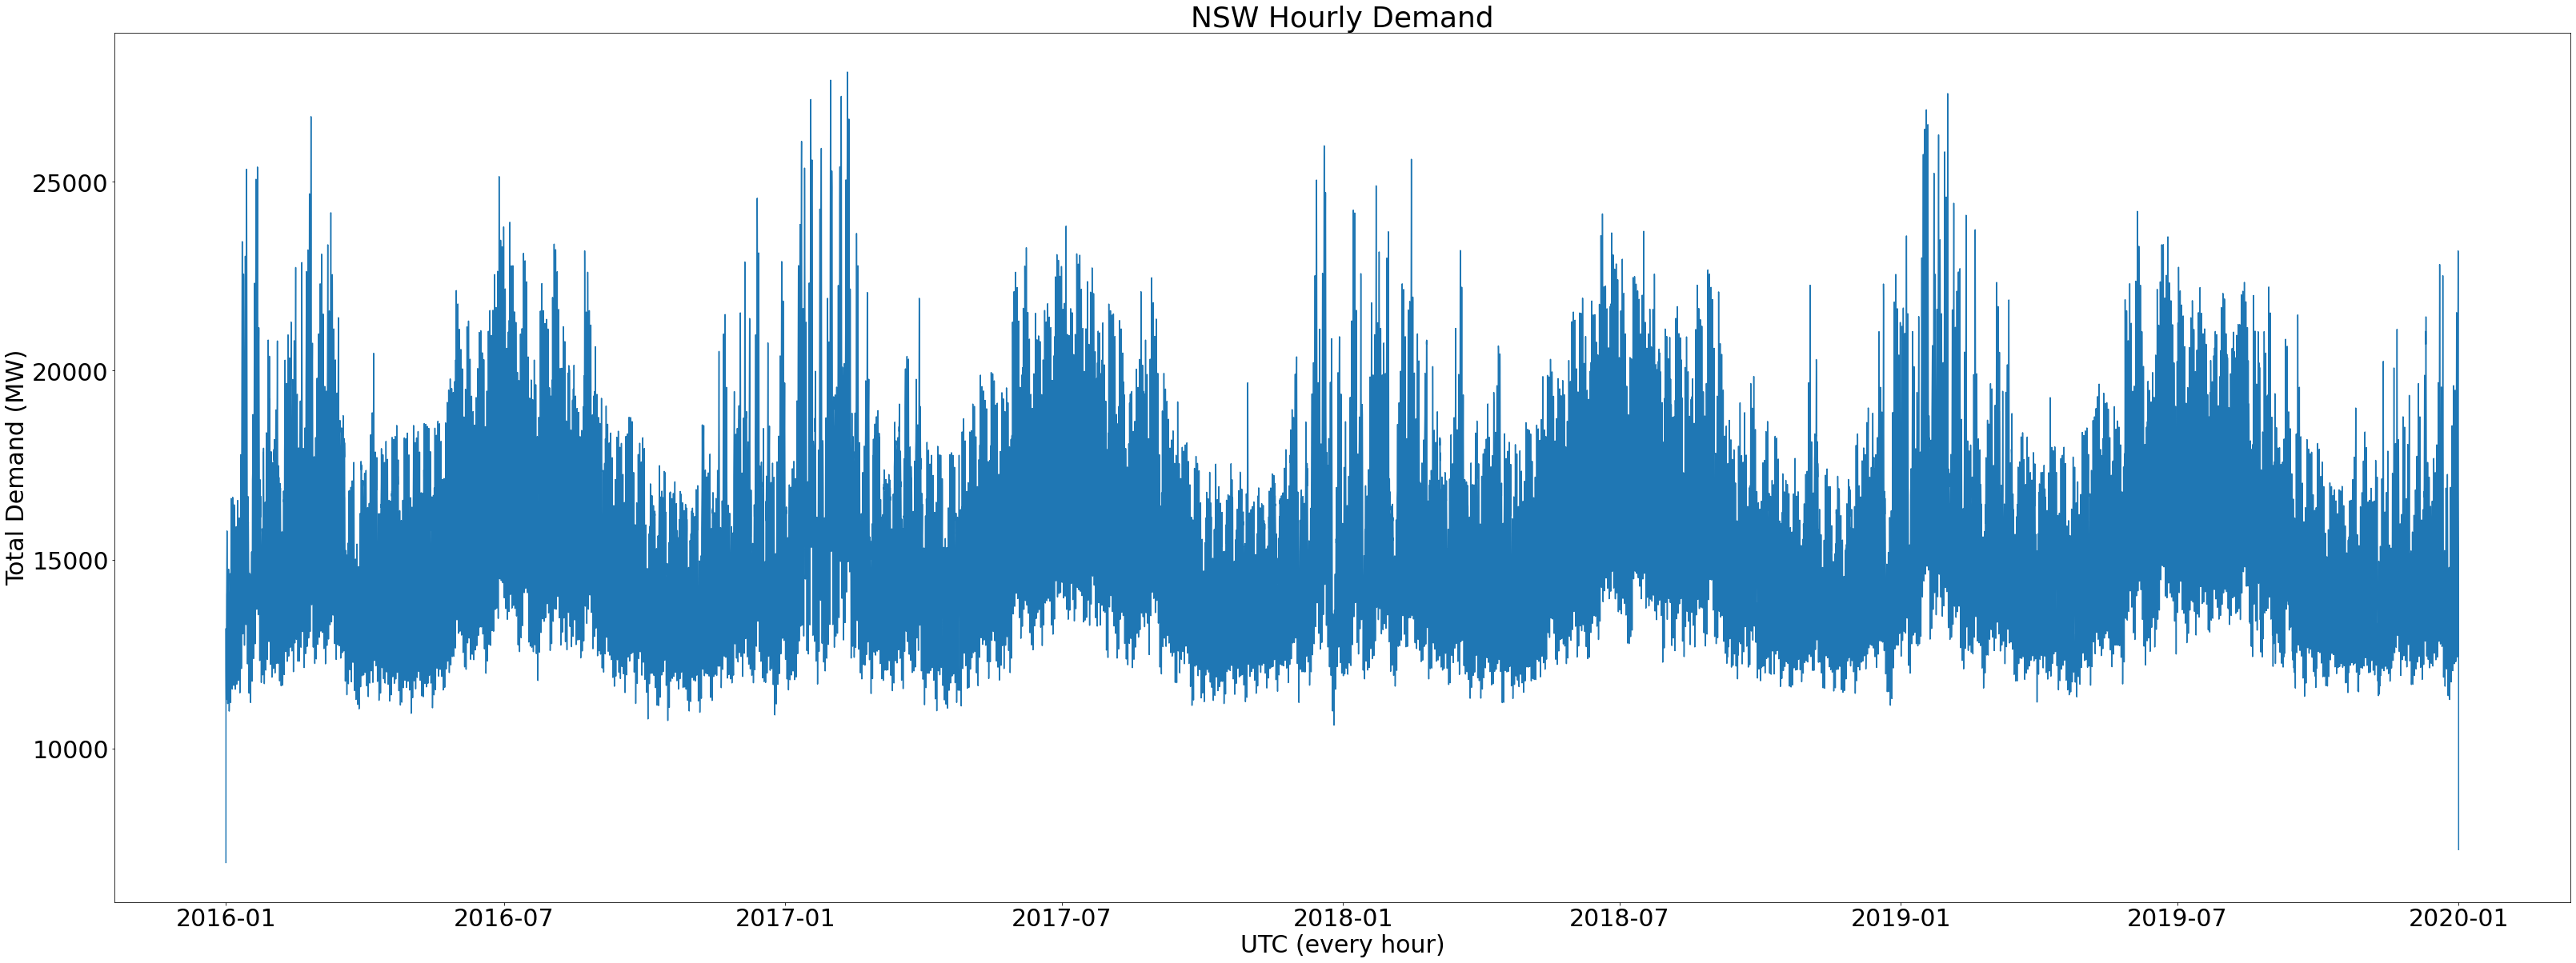

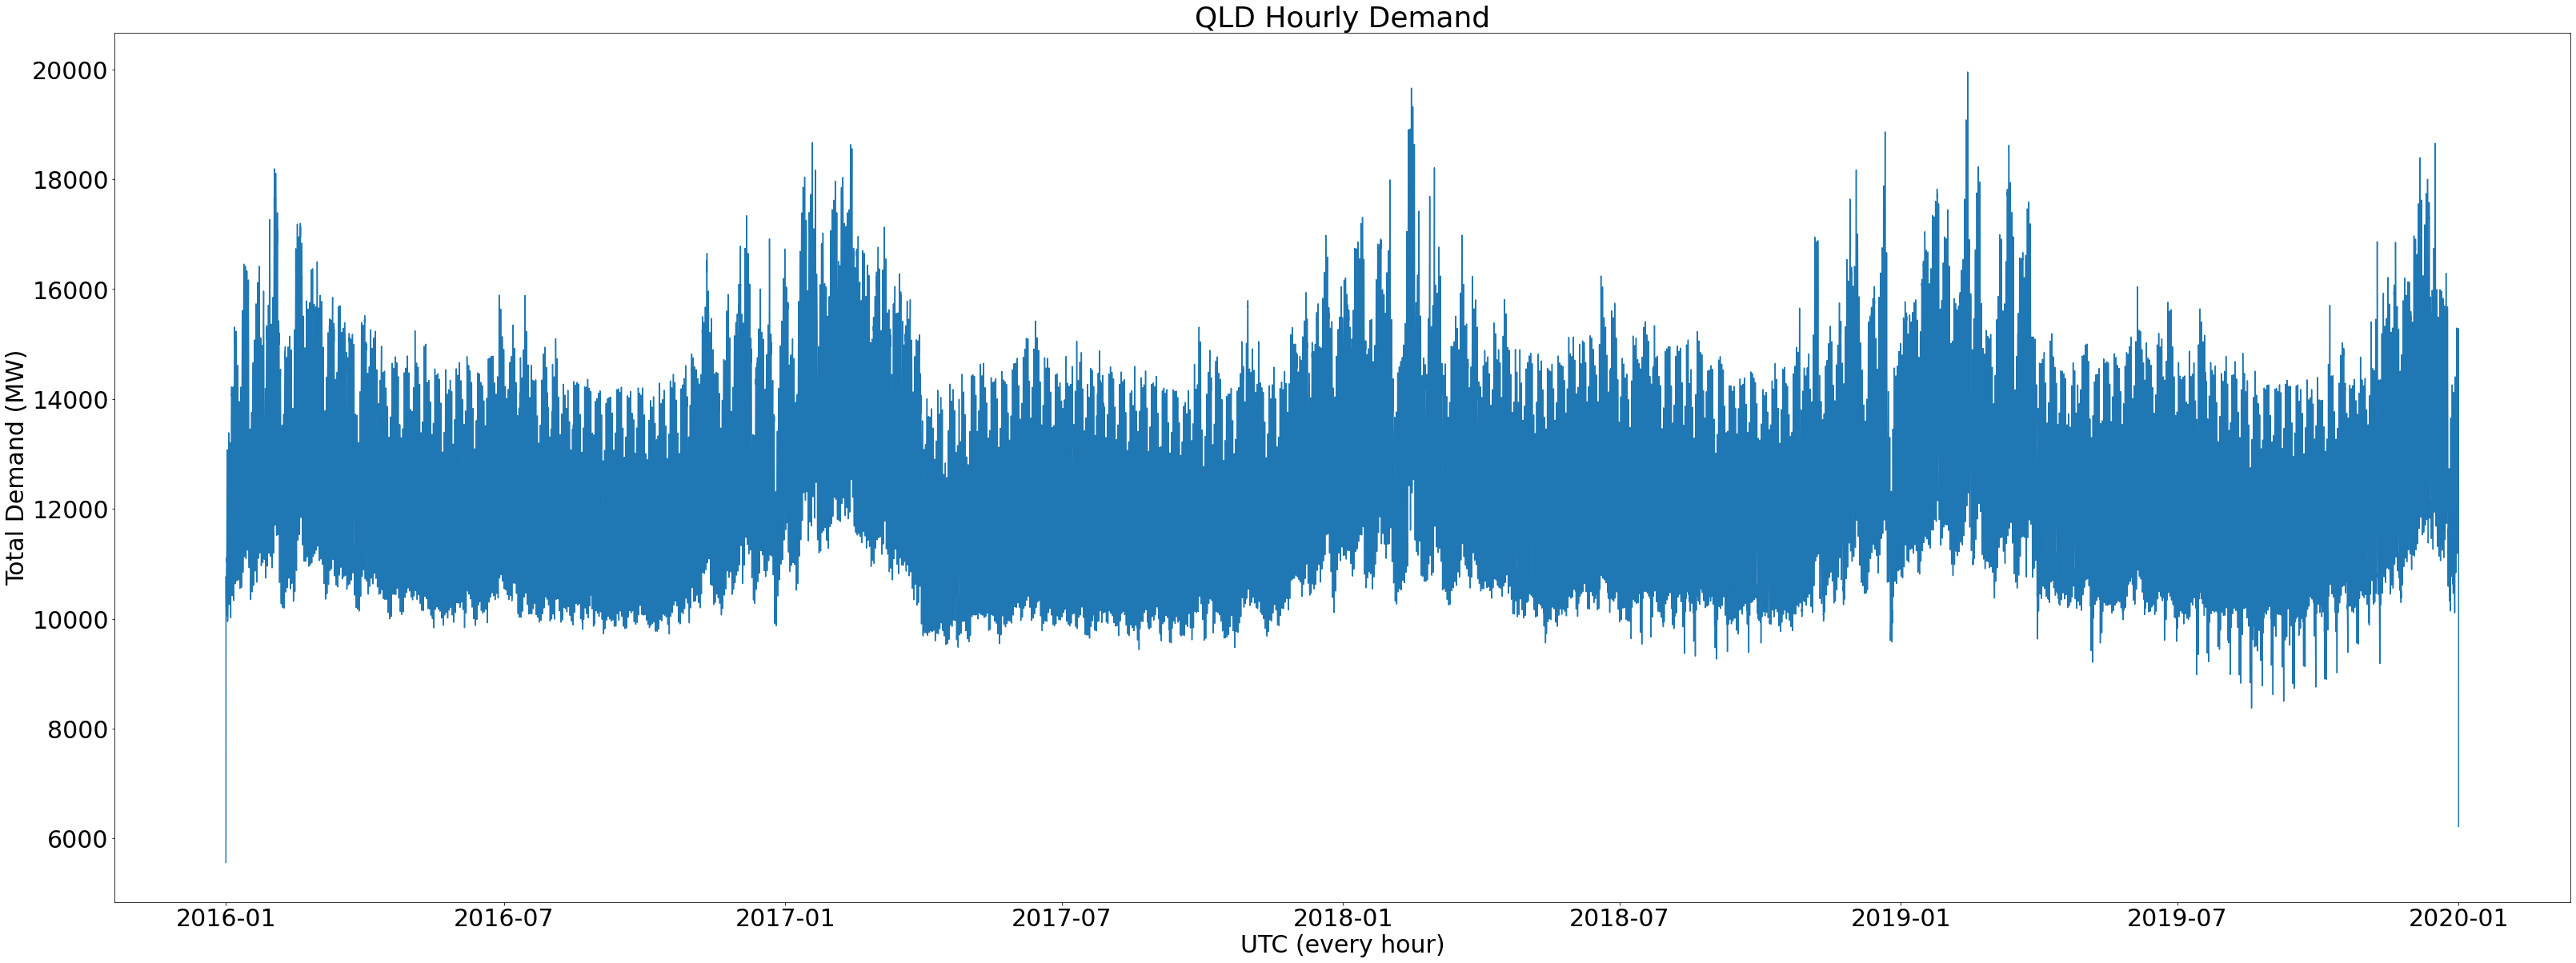

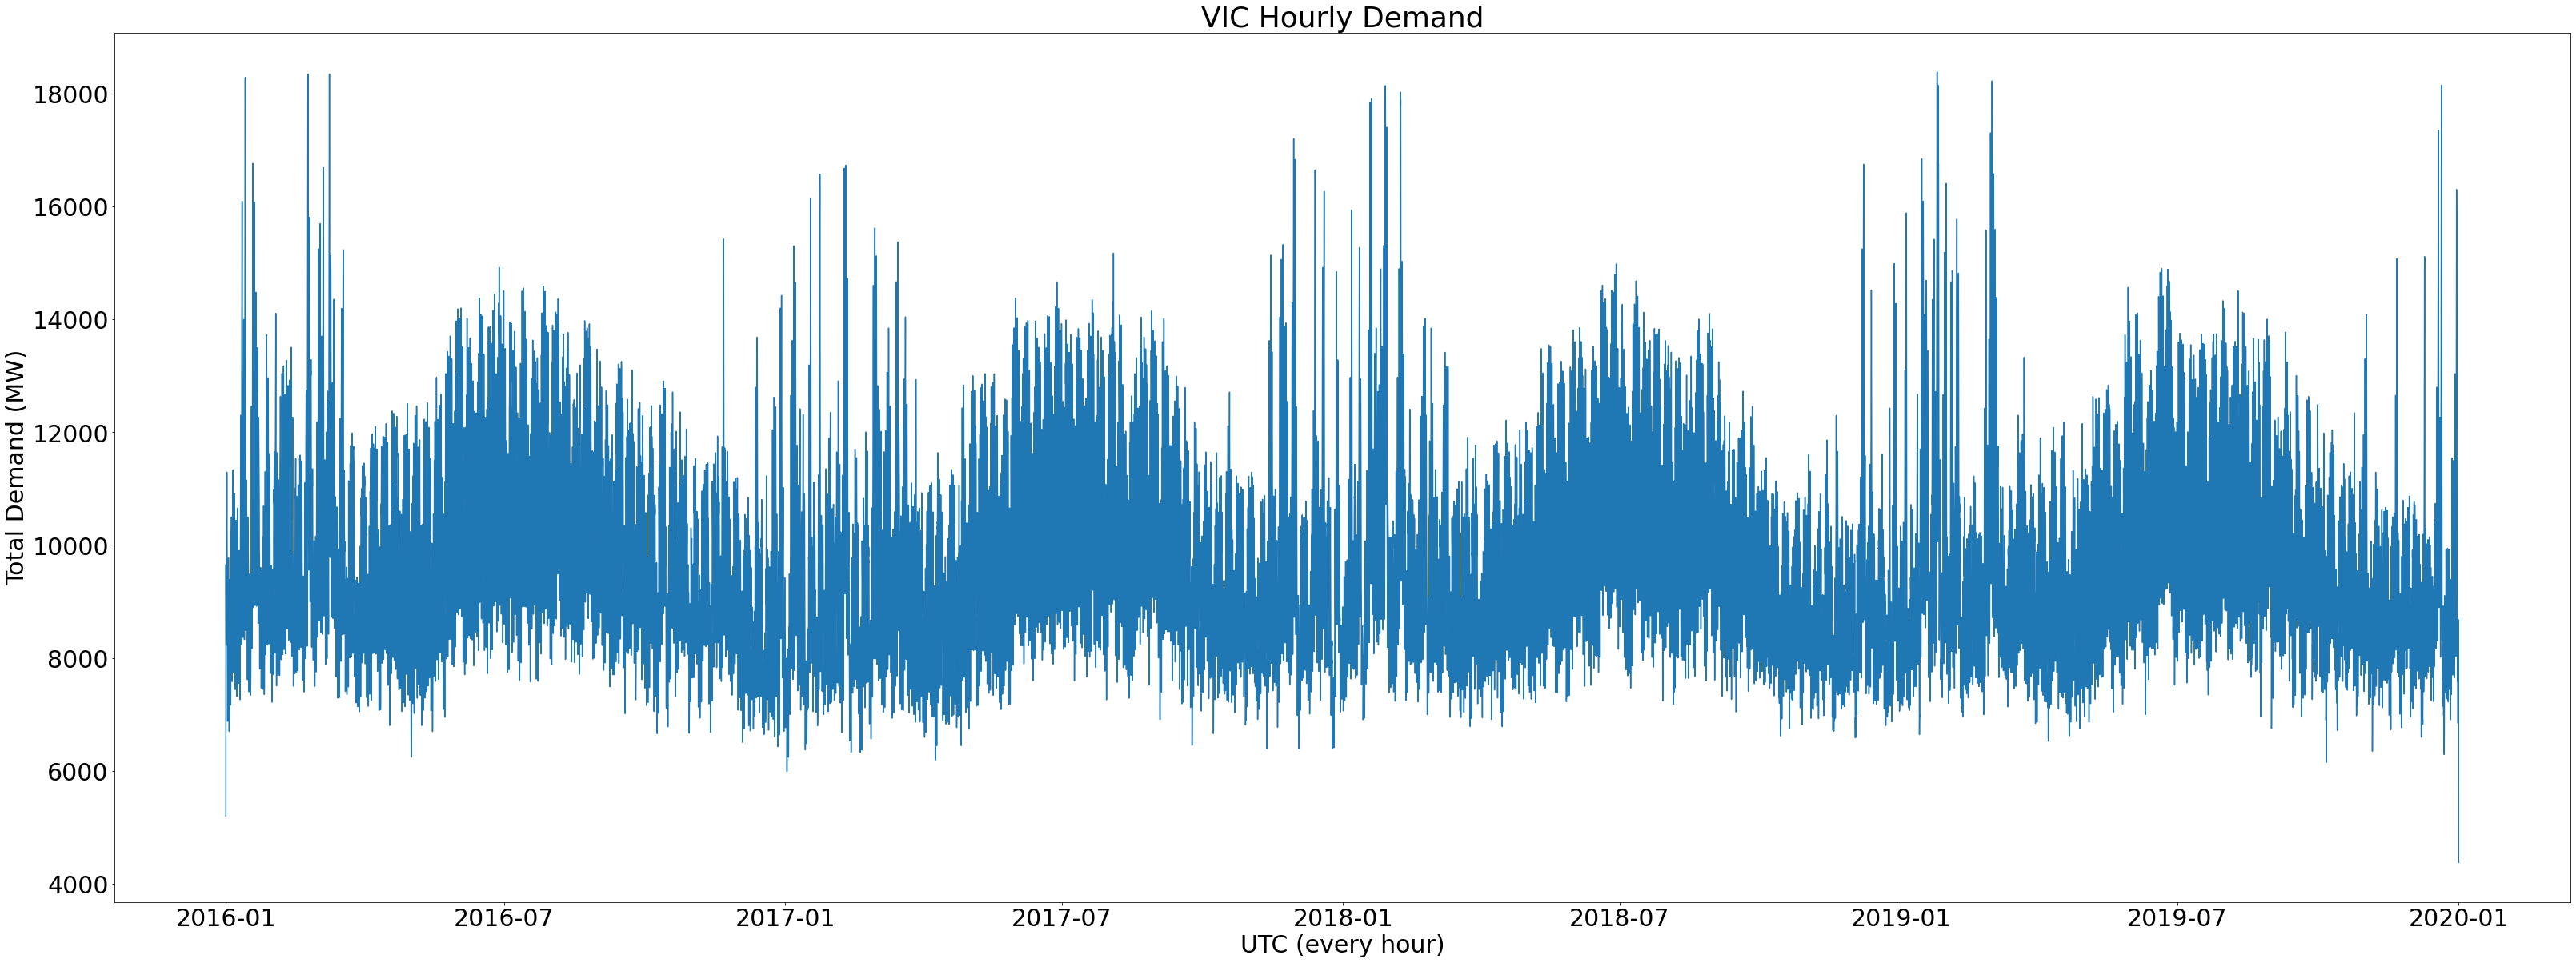

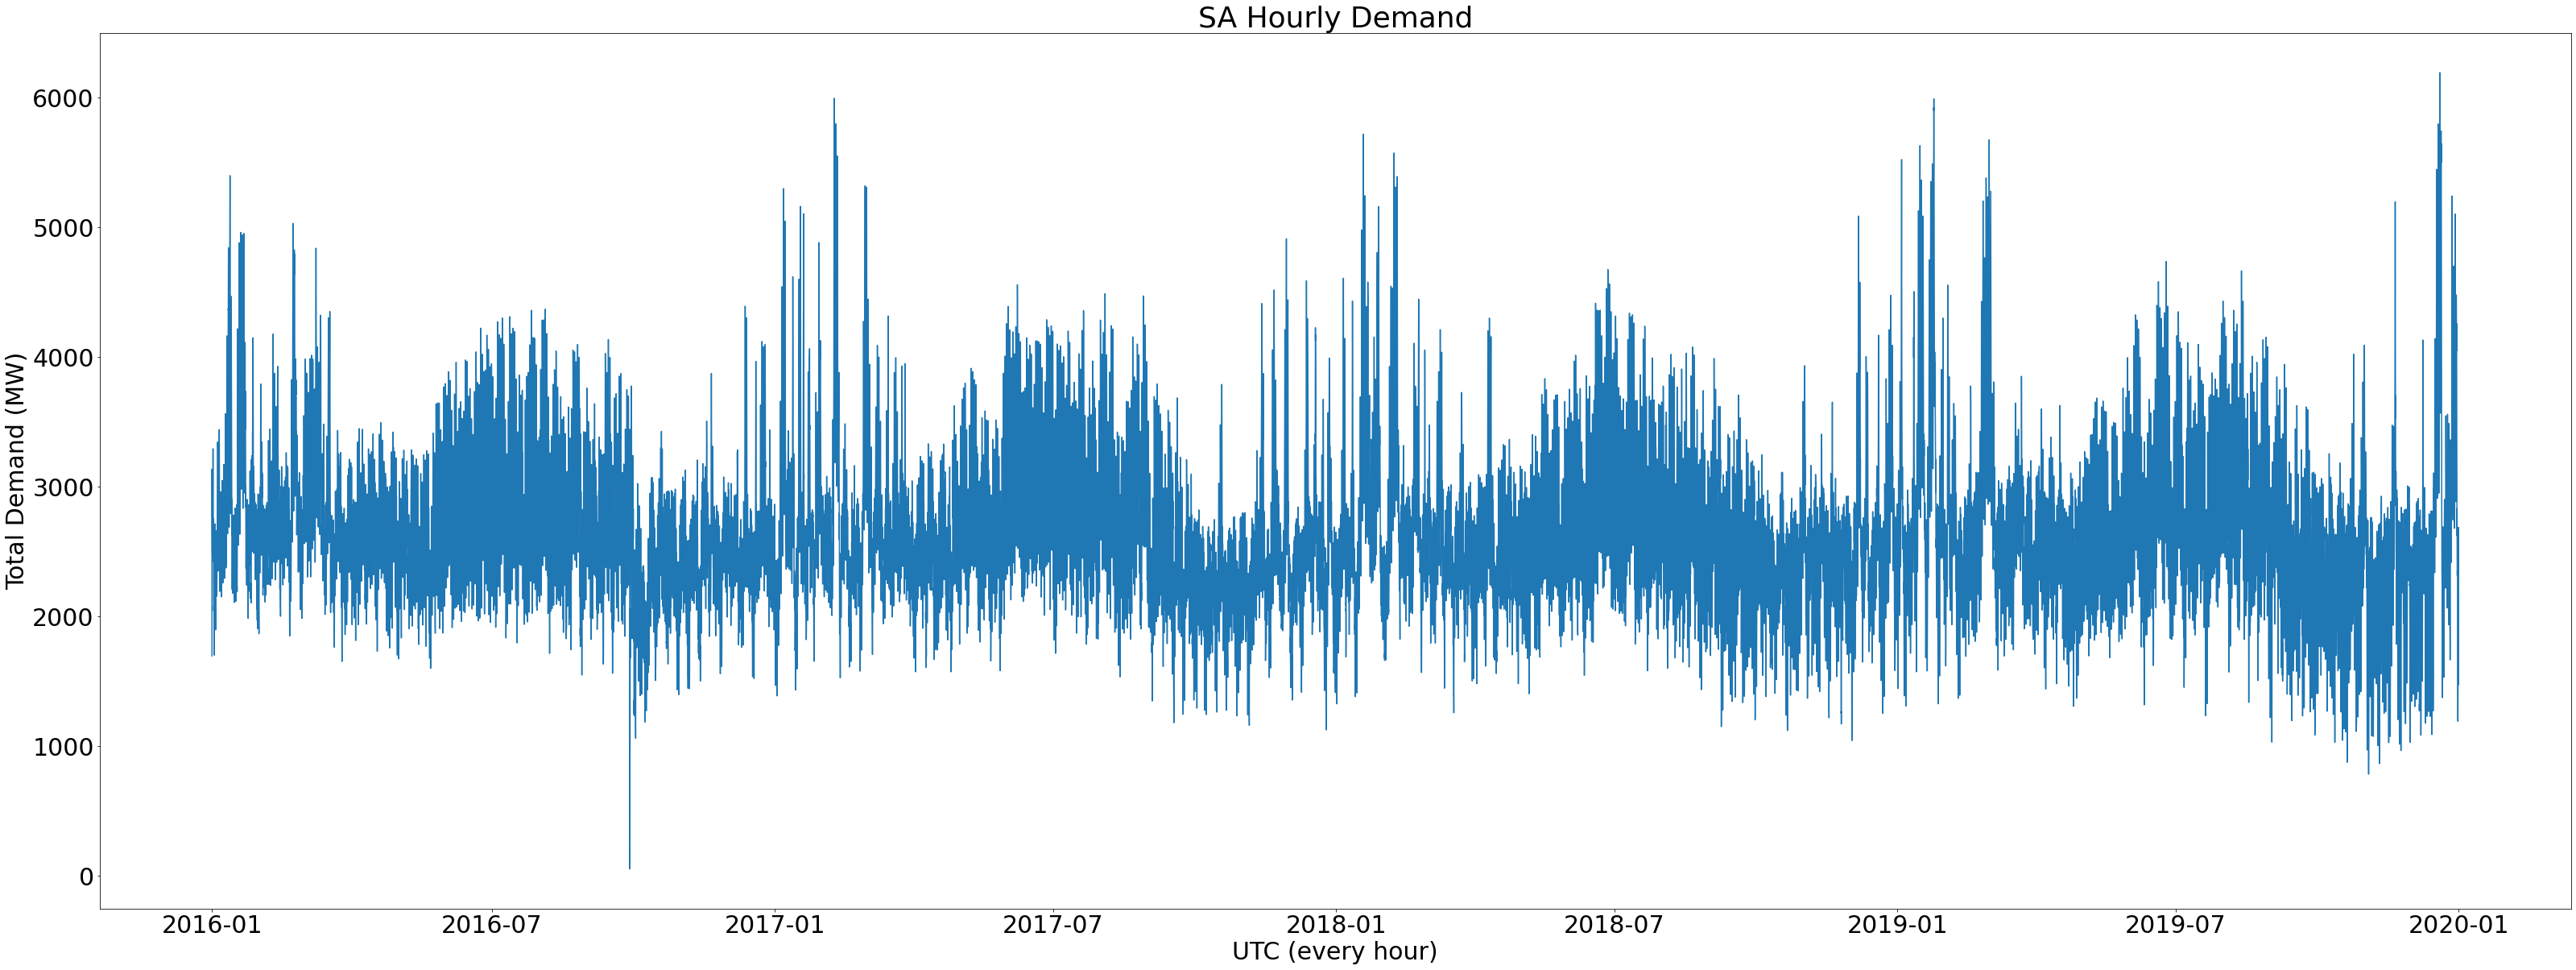

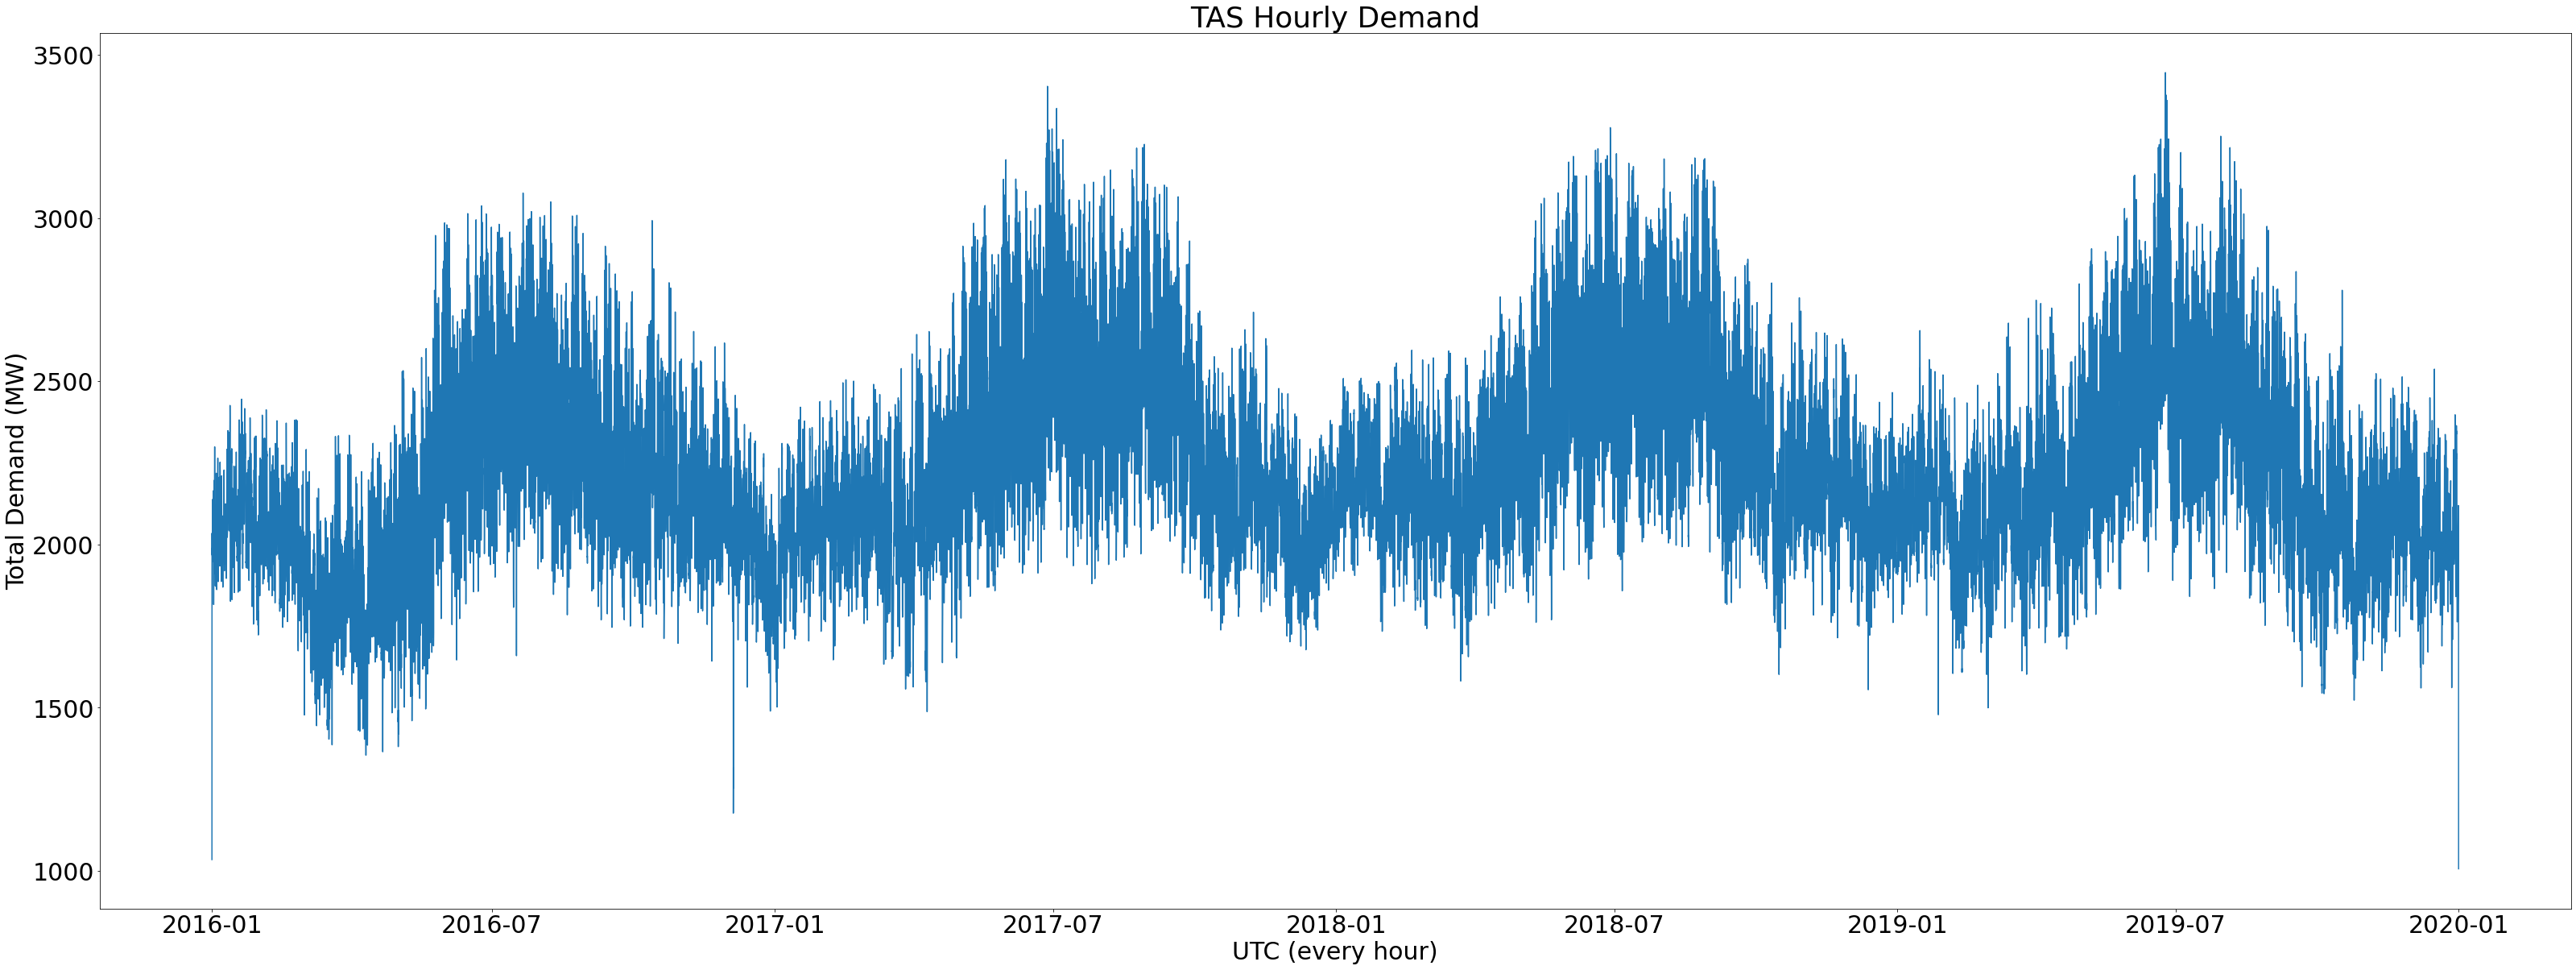

In [27]:
for region in regions:
    x = au_hourly.loc[(au_hourly["pca_abbrev"]==region+"1")].sort_values("timestamp")["timestamp"]
    y = au_hourly.loc[(au_hourly["pca_abbrev"]==region+"1")].sort_values("timestamp")["load_mw"]

    _ = plt.figure(figsize=(55,20))
    _ = plt.plot(x, y)
    _ = plt.xlabel("UTC (every hour)")
    _ = plt.ylabel("Total Demand (MW)")
    _ = plt.title(f"{region} Hourly Demand")
    _ = plt.show()

## Chile Energy Consumption

In [28]:
cl = cen.CEN(years)

In [29]:
cl_data = cl.get_cen_data()

2018


  0%|                  | 0/99 [00:00<?, ?it/s]

download_data: 11.45 seconds
unzip_files: 0.02 seconds


100%|█████████| 99/99 [00:13<00:00,  7.14it/s]


2017


  0%|                 | 0/365 [00:00<?, ?it/s]

download_data: 1.89 minutes
unzip_files: 0.01 seconds


100%|███████| 365/365 [04:28<00:00,  1.36it/s]


2016


  0%|                                              | 0/366 [00:00<?, ?it/s]

download_data: 59.73 seconds
unzip_files: 0.01 seconds


100%|████████████████████████████████████| 366/366 [04:16<00:00,  1.43it/s]


In [30]:
len(cl.errors)

0

In [31]:
cl_data.head()

,date,Centrales,1,2,3,4,5.0,6,7.0,8.0,...,20,21.0,22.0,23,24.0,Real,Máxima,Prog.,25.0,Total
0,2018-01-01,Total Generación SIC,5586.13,5586.54,5403.36,5168.44,4934.463841,4802.12,4661.904772,4523.939107,...,5411.9,5574.650418,6089.568176,6210.84,5923.152669,127087,6210.84,NaN,NaN,NaN
1,2018-01-02,Total Generación SIC,5563.29,5285.02,5060.24,4951.97,4946.521774,5114.27,5288.953742,5498.294224,...,7101.17,7122.330039,7471.706758,7335.39,6908.765731,157856,7793.84,NaN,NaN,NaN
2,2018-01-03,Total Generación SIC,6467.02,6056.39,5820.87,5669.2,5514.909245,5627.32,5820.001857,5956.964723,...,7039.02,6980.342747,7439.094768,7446.86,6974.695463,166648,7977.25,NaN,NaN,NaN
3,2018-01-04,Total Generación SIC,6503.89,6088.1,5866.77,5723.33,5643.904601,5732.1,5819.773981,6052.061607,...,7087.86,7110.611922,7529.913171,7460.52,7041.212406,165299,7725.31,NaN,NaN,NaN
4,2018-01-05,Total Generación SIC,6506.3,6123.73,5866.21,5730.75,5719.525878,5789.1,5889.826648,6119.921577,...,7062.76,6995.541304,7380.231951,7319.5,7068.237571,165646,7754.07,NaN,NaN,NaN


In [32]:
cl_melted = pd.melt(cl_data, id_vars=['date'], value_vars=[1,           2,           3,
                 4,         5.0,           6,         7.0,         8.0,
                 9,          10,          11,        12.0,          13,
              14.0,        15.0,          16,          17,        18.0,
              19.0,          20,        21.0,        22.0,          23,
              24.0])

In [33]:
cl_melted["local_time"] = cl_melted.apply(lambda x: datetime.datetime.strptime(str(x["date"]).split(" ")[0], "%Y-%m-%d") + datetime.timedelta(hours=x["variable"]), axis=1)

In [34]:
cl_timezone = -4 # gmt -4

In [35]:
cl_dst = {
    2016: {
        "end": datetime.datetime(year=2016, month=5, day=16, hour=0), # yyyymmddhh (-1 hour)
        "start": datetime.datetime(year=2016, month=8, day=14, hour=0) #"2016081400" # (+1 hour)
    },
    2017: {
        "end": datetime.datetime(year=2017, month=5, day=14, hour=0),#"2017051400",
        "start": datetime.datetime(year=2017, month=8, day=13, hour=0)#"2017081300"
    },
    2018: {
        "end": datetime.datetime(year=2018, month=5, day=13, hour=0),#"2018051300",
        "start": datetime.datetime(year=2018, month=8, day=12, hour=0)#"2018081200"
    }
}

In [36]:
def get_cl_time_adjustment(date):
    year = date.year
    dst_start = cl_dst[year]["start"]
    dst_end = cl_dst[year]["end"]
        
    if date >= dst_start:
        time_adjustment = cl_timezone -1
    else:
        time_adjustment = cl_timezone

    return time_adjustment

In [37]:
def convert_cl_timezones(local_time, time_adjustment):
    utc = local_time + datetime.timedelta(hours=time_adjustment)
    return utc

In [38]:
cl_melted["time_adjustment"] = cl_melted["local_time"].map(get_cl_time_adjustment)

In [39]:
cl_melted["utc"] = cl_melted.apply(lambda x: convert_cl_timezones(x["local_time"], x["time_adjustment"]), axis=1)

In [40]:
cl_melted["pca_abbrev"] = "CL"
cl_melted["source"] = "CL"

In [41]:
cl_melted.rename(columns={"value": "load_mw", "utc": "timestamp"}, inplace=True)

In [42]:
cl_melted["load_mw"] = cl_melted["load_mw"].astype(int)

In [43]:
cl_melted[["timestamp", "pca_abbrev", "load_mw", "source"]].to_csv("data/chile_hourly_consumption.csv", index=None)

In [44]:
cl_melted.shape

(19920, 8)

In [45]:
cl_melted["year"] = cl_melted["date"].map(lambda x: x.year)

In [46]:
expected_annual_hours

8760

In [47]:
# compare with expected annual hours
cl_melted.groupby("year").agg(total_hours=("timestamp", "count"))

,total_hours
year,
2016,8784
2017,8760
2018,2376


In [48]:
cl_melted.head()

,date,variable,load_mw,local_time,time_adjustment,timestamp,pca_abbrev,source,year
0,2018-01-01,1,5586,2018-01-01 01:00:00,-4,2017-12-31 21:00:00,CL,CL,2018
1,2018-01-02,1,5563,2018-01-02 01:00:00,-4,2018-01-01 21:00:00,CL,CL,2018
2,2018-01-03,1,6467,2018-01-03 01:00:00,-4,2018-01-02 21:00:00,CL,CL,2018
3,2018-01-04,1,6503,2018-01-04 01:00:00,-4,2018-01-03 21:00:00,CL,CL,2018
4,2018-01-05,1,6506,2018-01-05 01:00:00,-4,2018-01-04 21:00:00,CL,CL,2018


In [49]:
cl_melted["timestamp"].unique().shape

(19918,)

In [50]:
cl_melted["load_mw"].describe()

count    19920.000000
mean      6240.875803
std        832.180385
min          0.000000
25%       5536.000000
50%       6284.500000
75%       6929.000000
max       8218.000000
Name: load_mw, dtype: float64

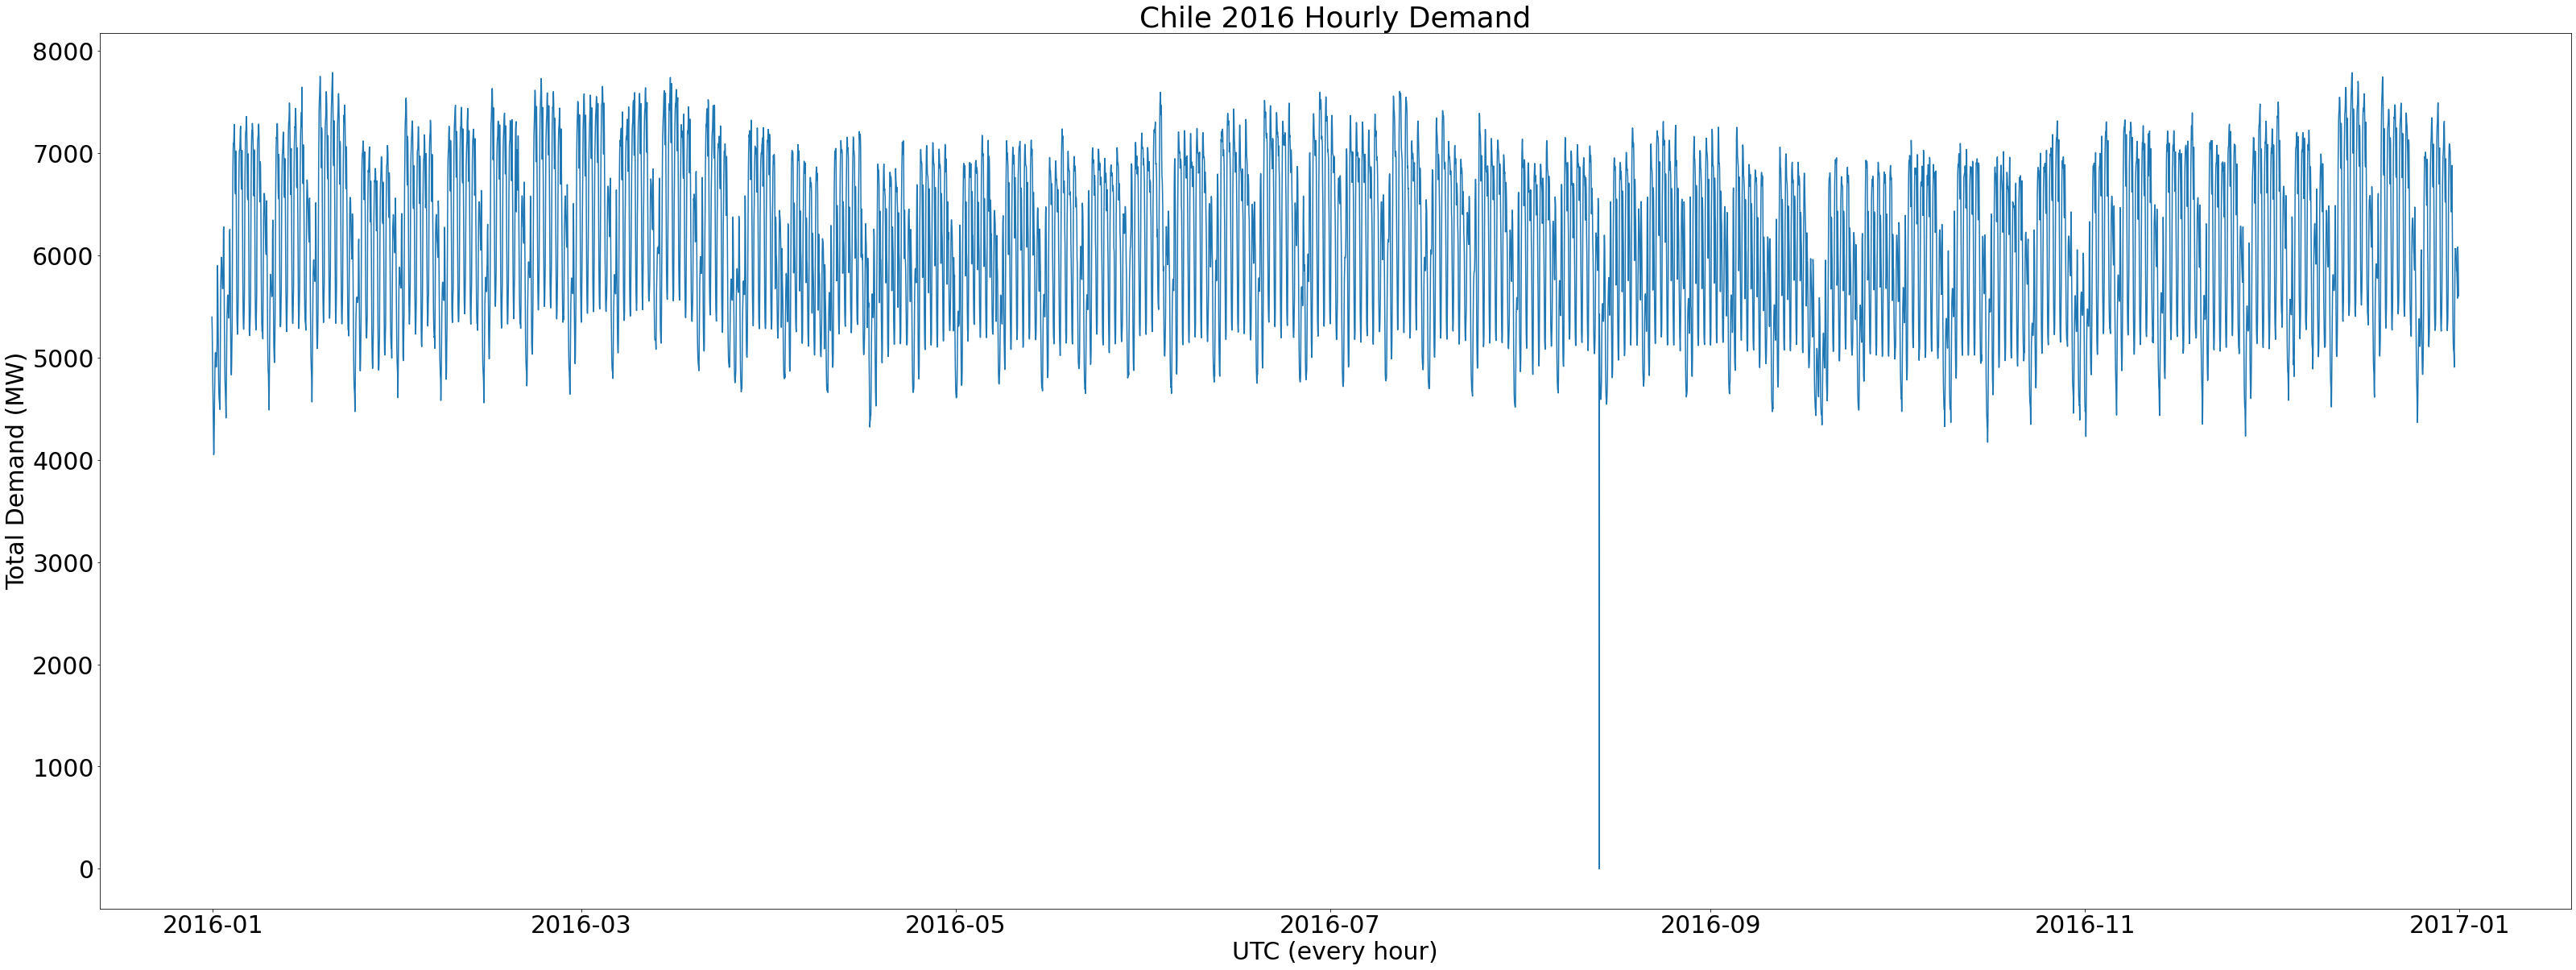

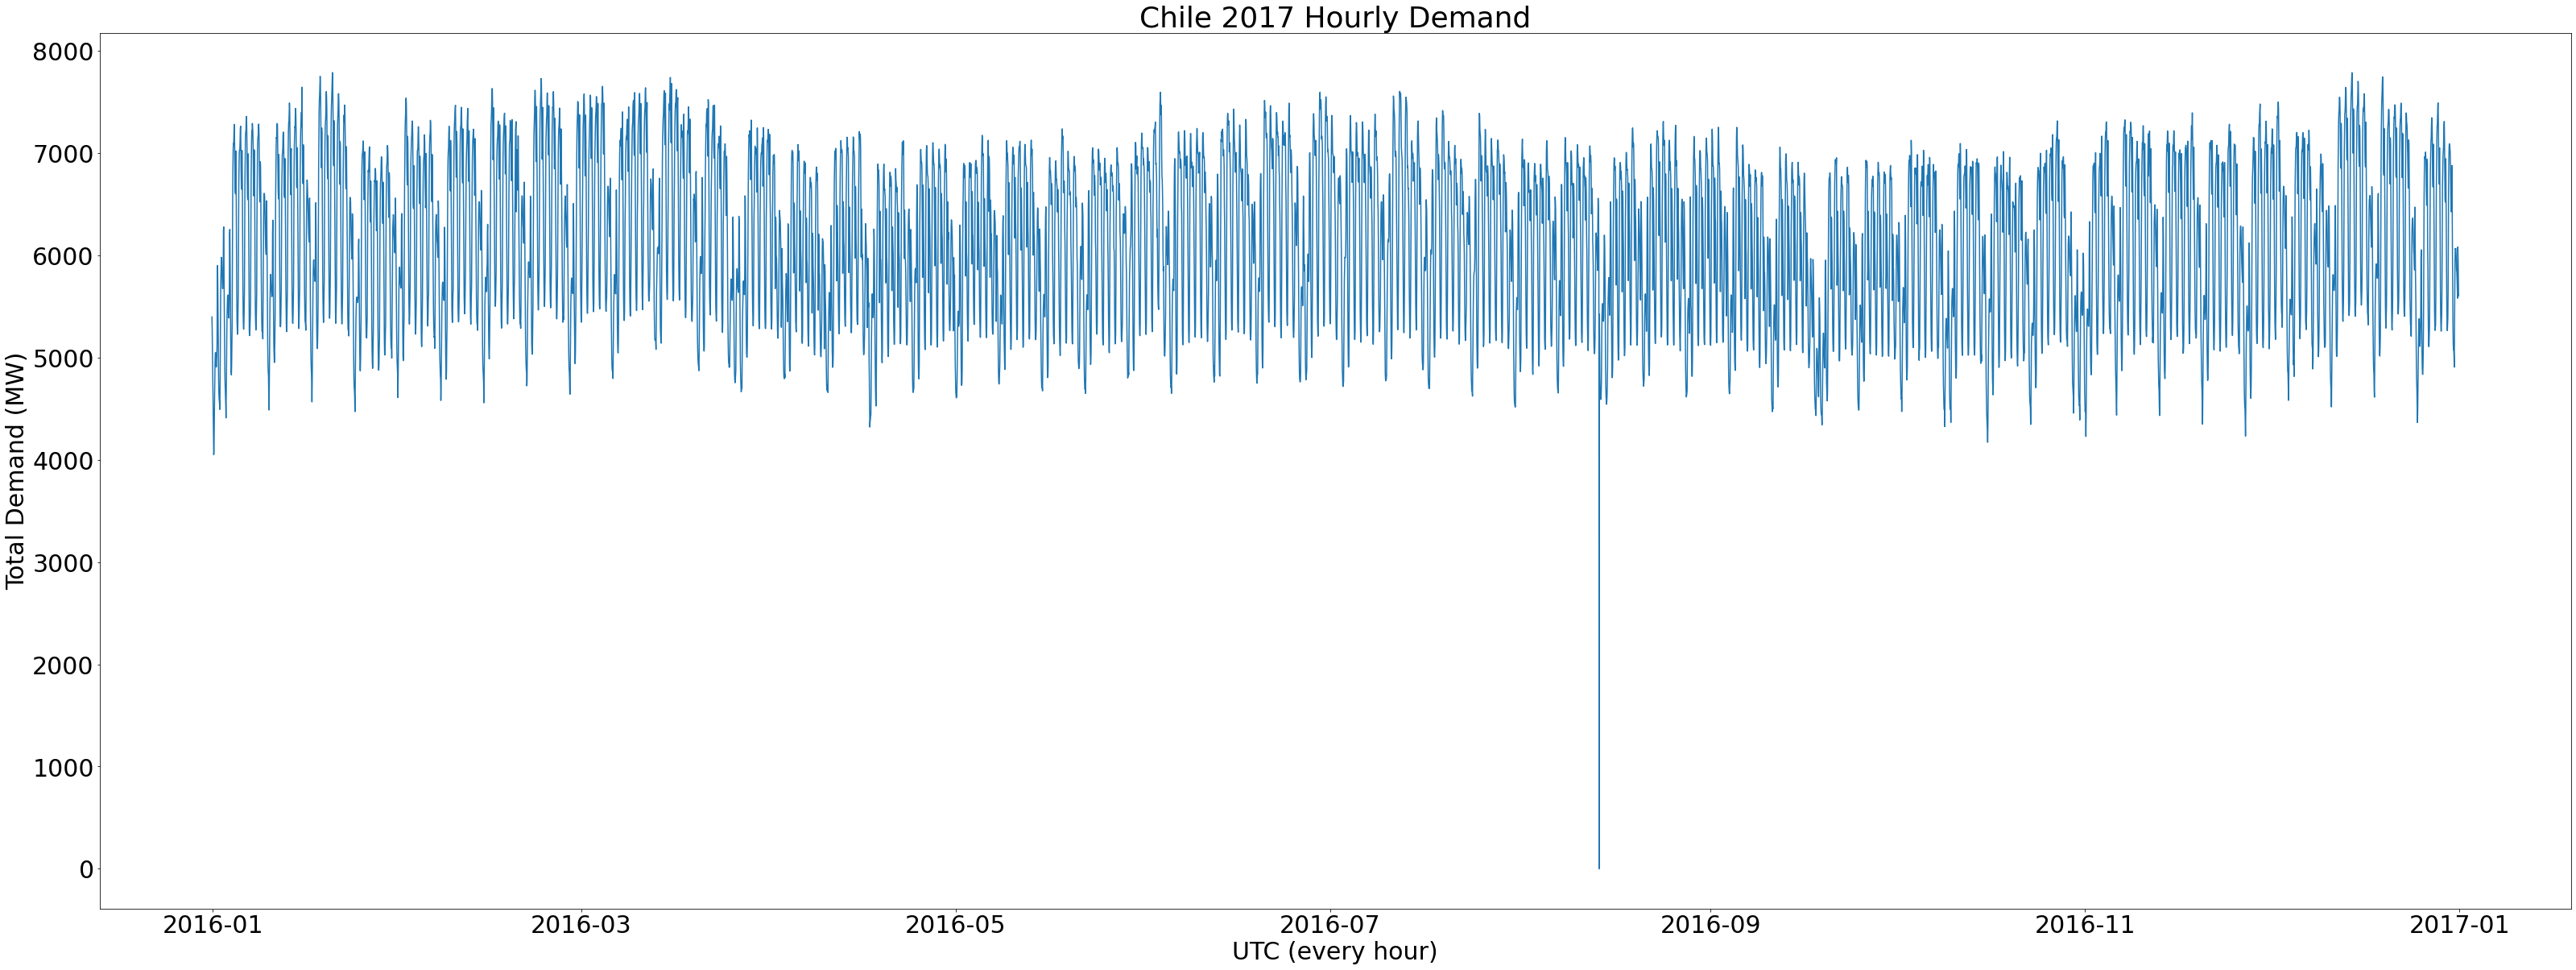

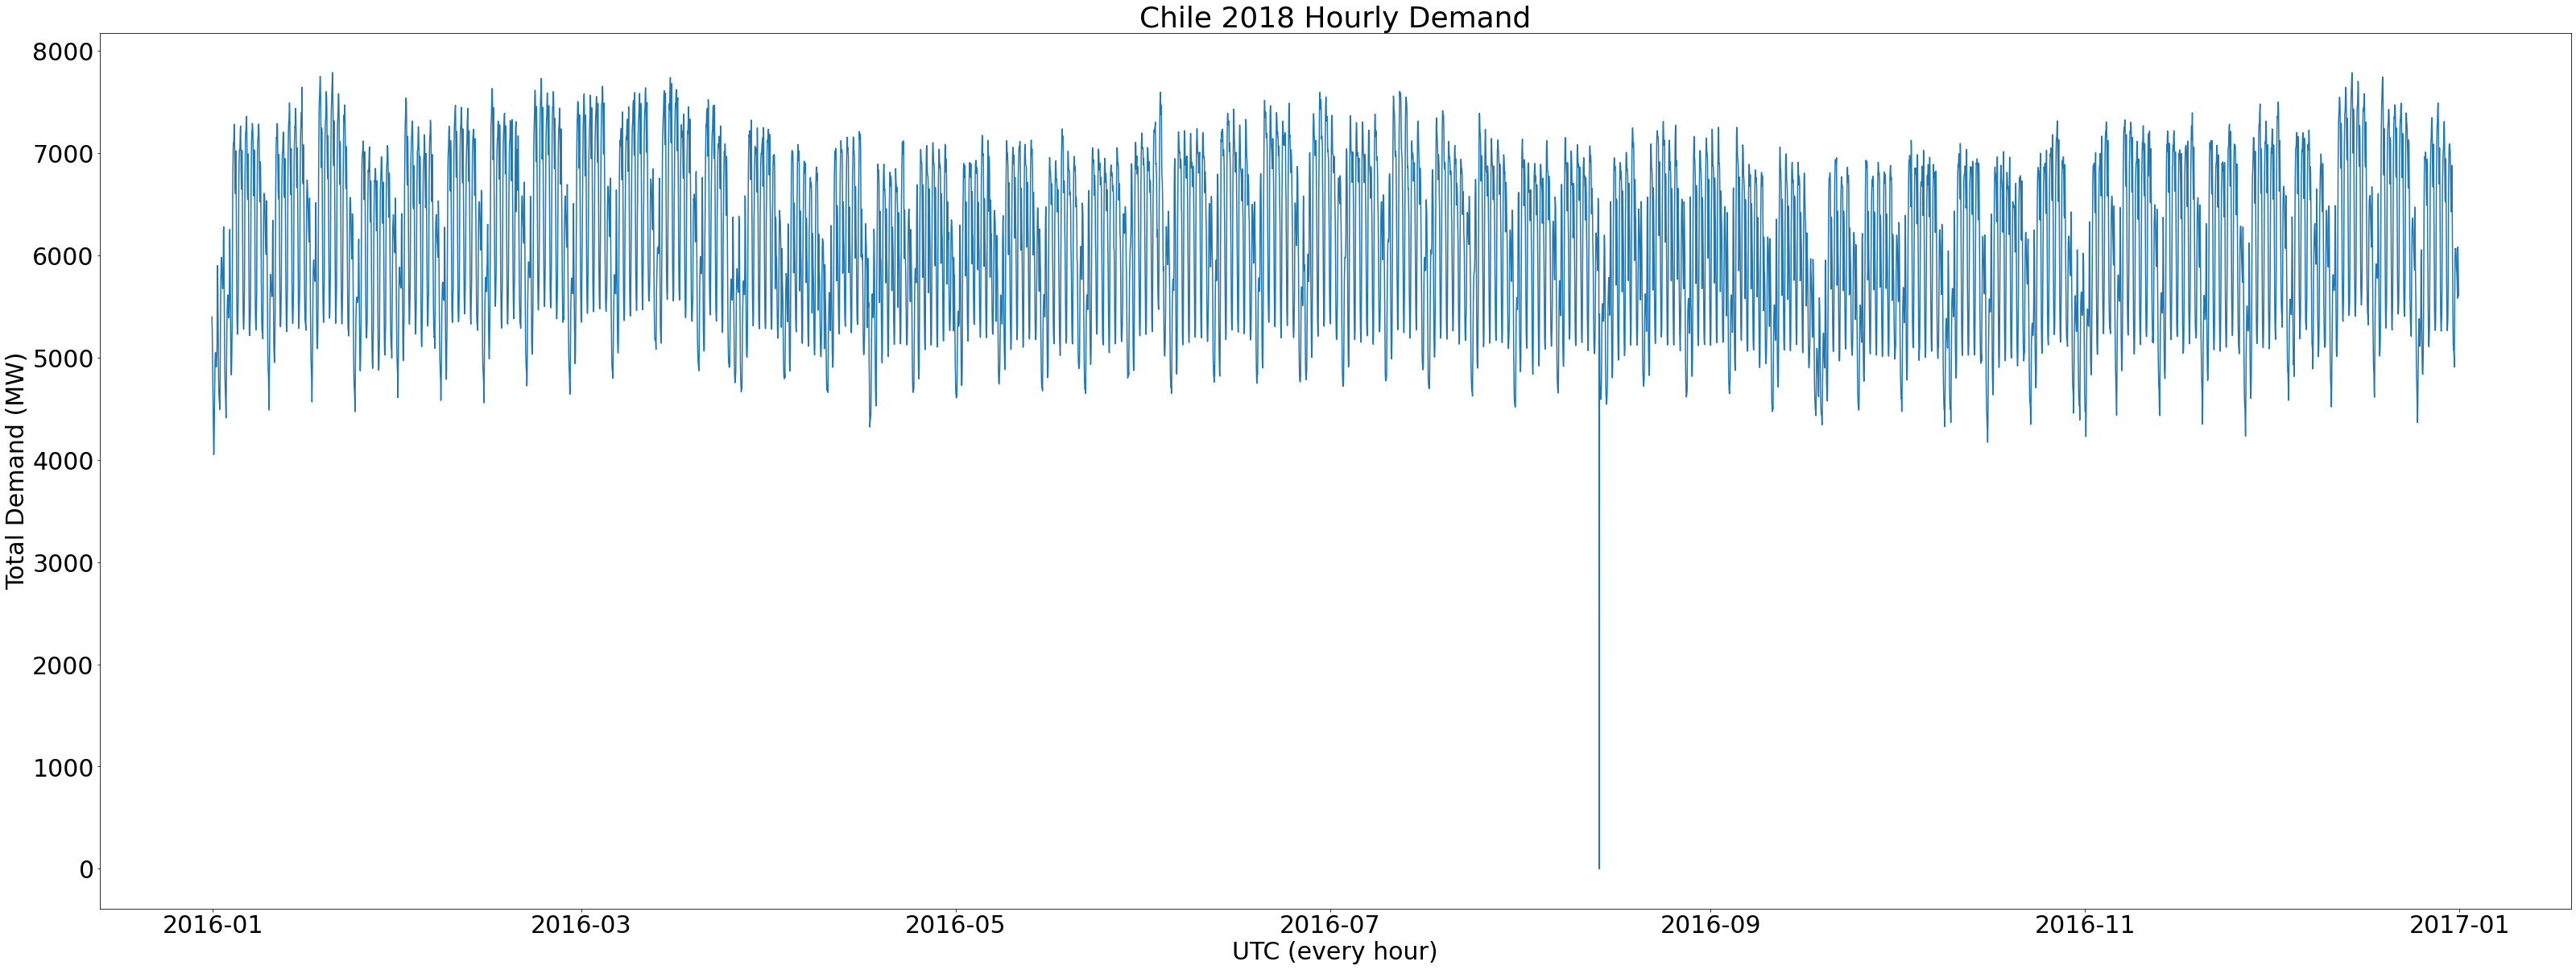

In [51]:
for year in [2016, 2017, 2018]:
    x = cl_melted.loc[cl_melted["year"]==2016].sort_values("timestamp")["timestamp"]
    y = cl_melted.loc[cl_melted["year"]==2016].sort_values("timestamp")["load_mw"]

    _ = plt.figure(figsize=(55,20))
    _ = plt.plot(x, y)
    _ = plt.xlabel("UTC (every hour)")
    _ = plt.ylabel("Total Demand (MW)")
    _ = plt.title(f"Chile {year} Hourly Demand")
    _ = plt.show()